# **Assignment 2 ROB313**

In [3]:
# Import revelant libraries

import numpy as np
import matplotlib.pyplot as plt
from time import time
from data.data_utils import load_dataset
from scipy.linalg import cho_factor, cho_solve, svd
np.random.seed(21)

 **Question 3 - Creating a Radial Basis Function (RBF)**

In [15]:
def gaussian_kernel(x_train, x_test, theta):
    # reshape the matricies correctly for broadcasting
    x = np.expand_dims(x_train, axis=1)
    z = np.expand_dims(x_test, axis=0)
    # now evaluate the kernel using the euclidean distances squared between points
    return np.exp(-np.sum(np.square(x-z)/theta, axis=2, keepdims=False))

def rbf_model(x_train, y_train, x_valid, y_valid):
    '''Format data, determine alpha by calculating gram matrix and usng Cholesky factorization, apply RBF model, iterate over values of theta and lamda and store RMSE info'''
    thet = np.array([0.05, 0.1, 0.5, 1, 2])
    lam = np.array([0.001, 0.01, 0.1, 1])
    rmse = np.zeros((thet.shape[0], lam.shape[0]))
    # Select hyperparameters by evaluating on the validation set
    for i,theta in enumerate(thet):
        for j,lamda in enumerate(lam):
            K = gaussian_kernel(x_train, x_train, theta)
            C = cho_factor(K + lamda*np.identity(x_train.shape[0]))
            alpha = cho_solve(C,y_train)
            # Use x_train as the landmarks (basis vectors) for predicting on validation set
            y_rbf = gaussian_kernel(x_valid, x_train, theta).dot(alpha)
            rmse[i][j] = np.sqrt(np.mean(np.square(y_rbf-y_valid)))
    # Determine hyperparameters with smallest error
    min_ind = np.unravel_index(np.argmin(rmse, axis=None), rmse.shape)
    theta_best = thet[min_ind[0]]
    lamda_best = lam[min_ind[1]]

    return theta_best, lamda_best

def test_rbf(x_train, y_train, x_valid, y_valid, x_test, y_test, theta, lamda):
    # Use training and validation sets to predict on test set
    x_train = np.vstack([x_valid, x_train])
    y_train = np.vstack([y_valid, y_train])

    # Calculate RBF using hyperparameters given
    K = gaussian_kernel(x_train, x_train, theta)
    C = cho_factor(K + lamda*np.identity(x_train.shape[0]))
    alpha = cho_solve(C,y_train)
    # Use x_train as the landmarks (basis vectors) for predicting on test set
    y_rbf = gaussian_kernel(x_test, x_train, theta).dot(alpha)
    rmse = np.sqrt(np.mean(np.square(y_rbf-y_test)))

    return rmse
    
def run_Q3(dataset):
    if dataset == 'mauna_loa':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
    elif dataset == 'rosenbrock':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)

    # Determine hyperparameters (regularization and shape) using training and validation sets
    theta, lamda = rbf_model(x_train, y_train, x_valid, y_valid)
    # Assess hyperparameter choices against test data
    test_rmse = test_rbf(x_train, y_train, x_valid, y_valid, x_test, y_test, theta, lamda)

    return test_rmse, theta, lamda

run_Q3('mauna_loa')

(0.14977338771884008, 1.0, 0.001)

**Results:**

Mauna Loa:
- Test RMSE: 0.14977338771884008
- Theta: 1.0
- Lamda = 0.001

Rosenbrock:
- Test RMSE: 0.14812442755080485
- Theta: 2.0
- Lamda: 0.001

 **Question 4 - Implementing Greedy Regression Algorithm**

0.04558218468536857

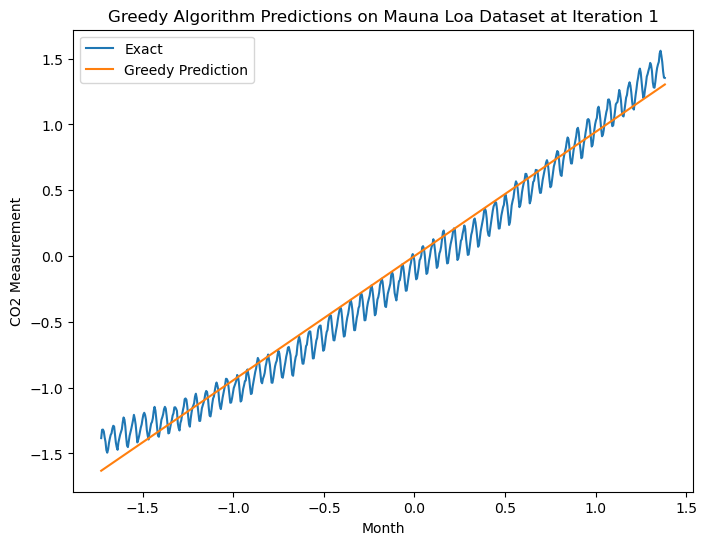

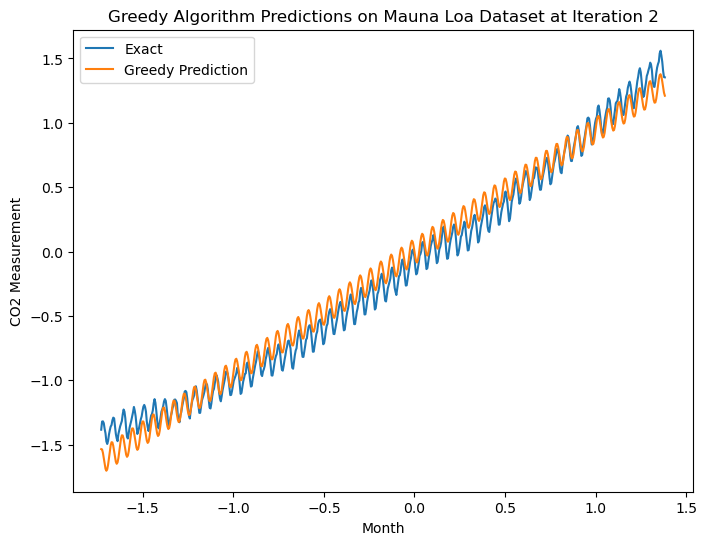

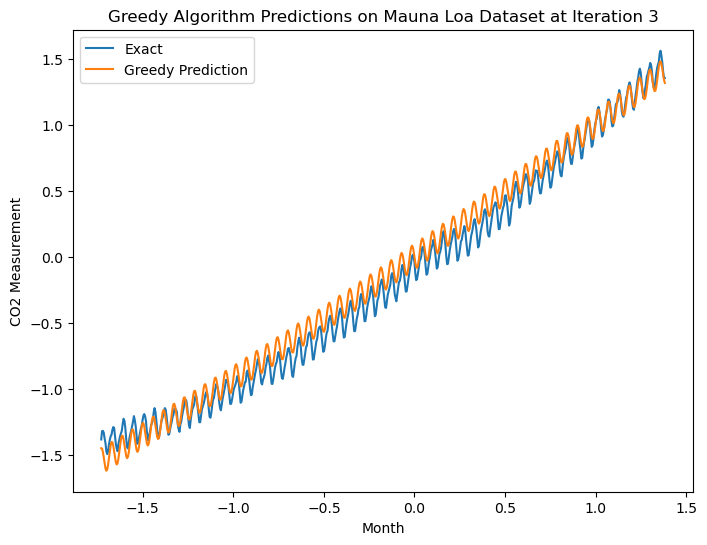

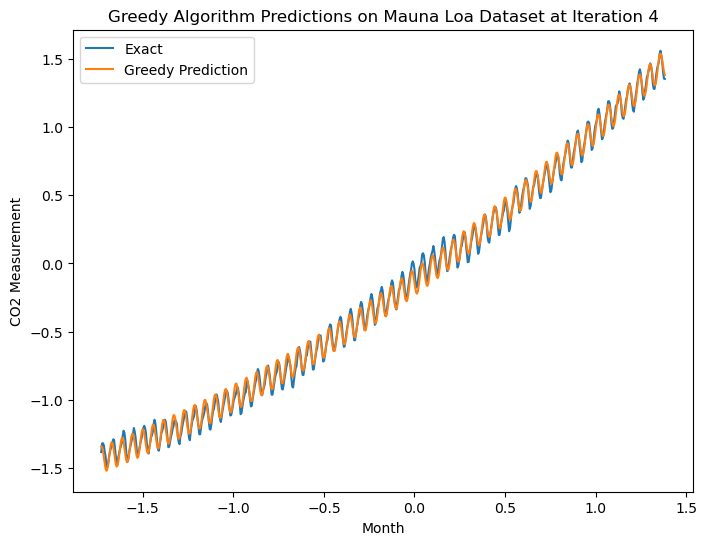

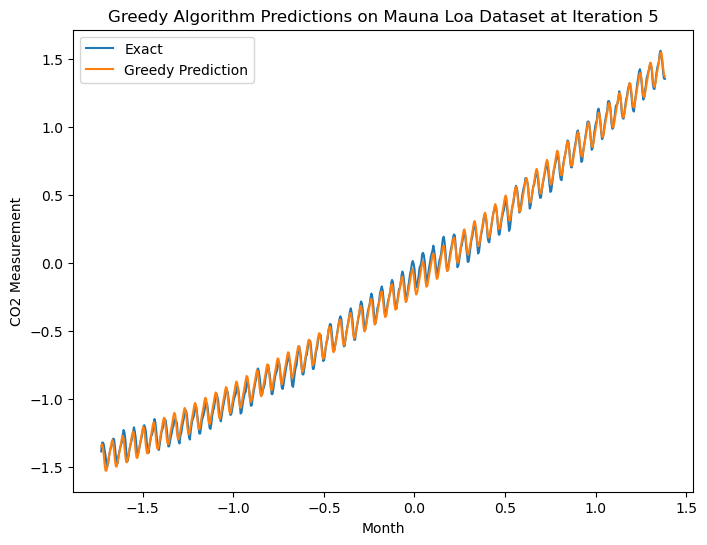

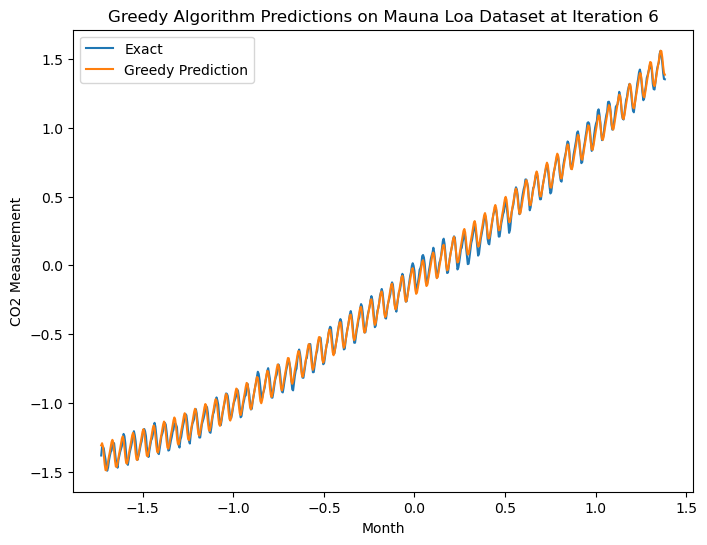

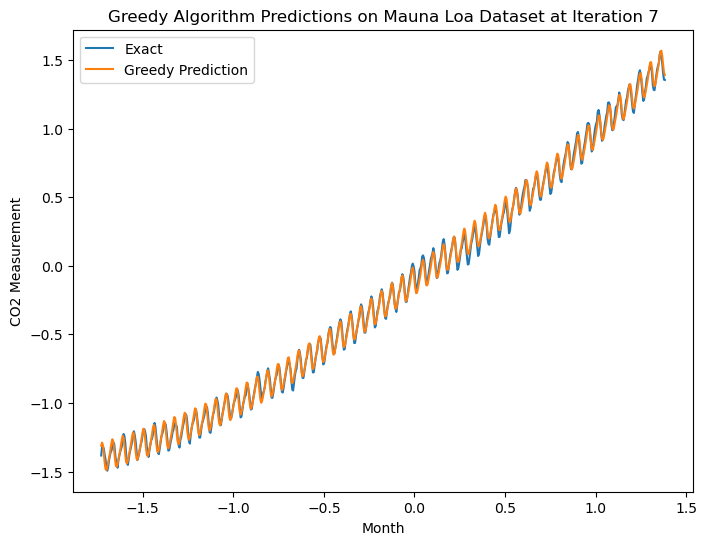

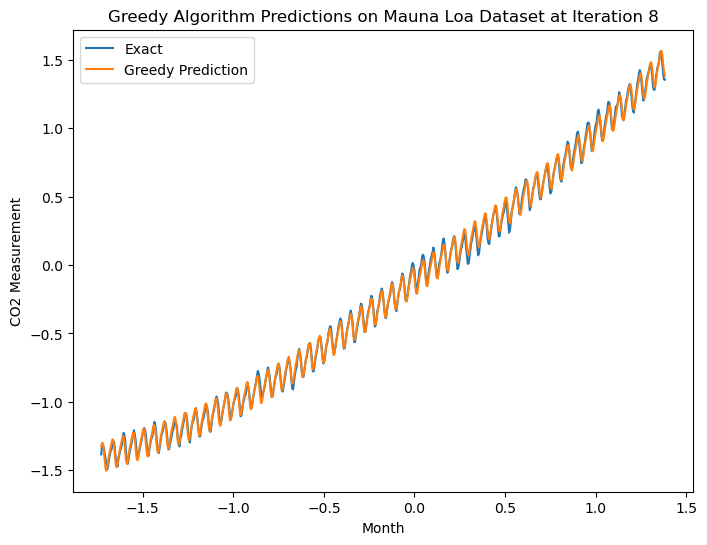

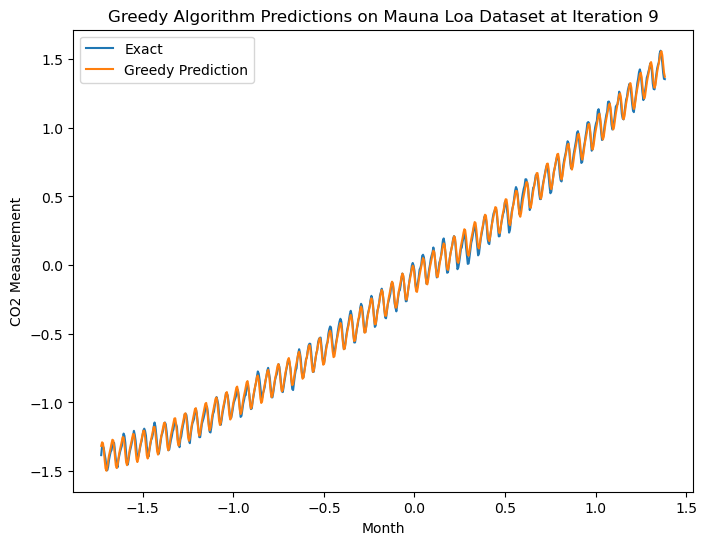

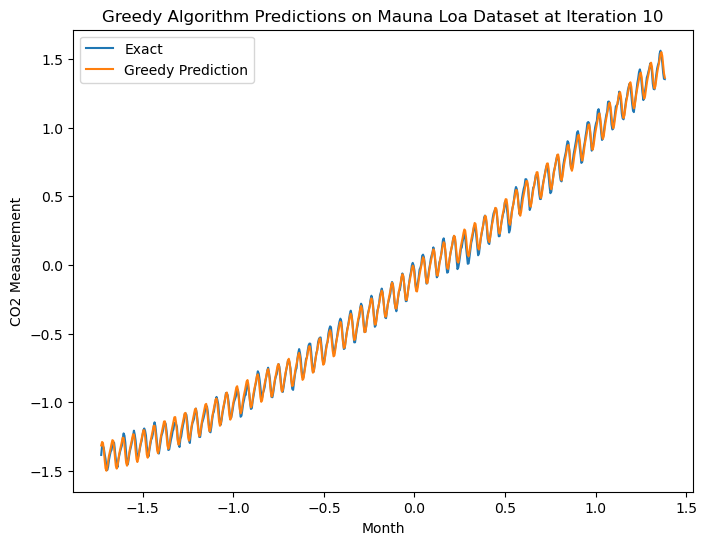

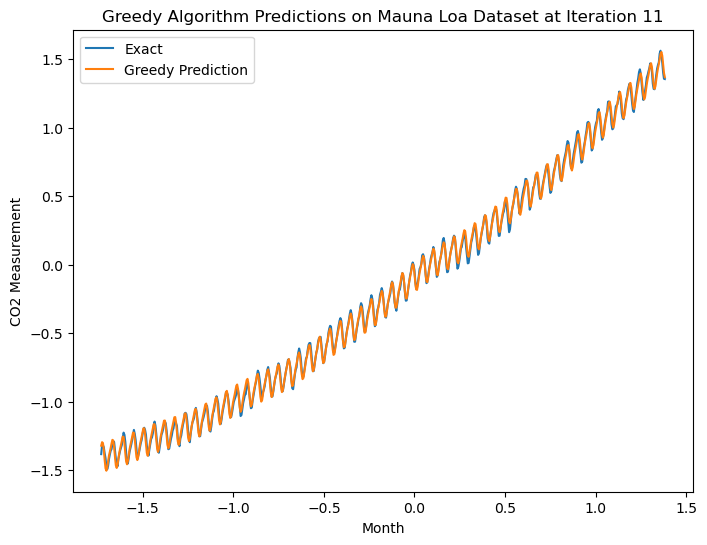

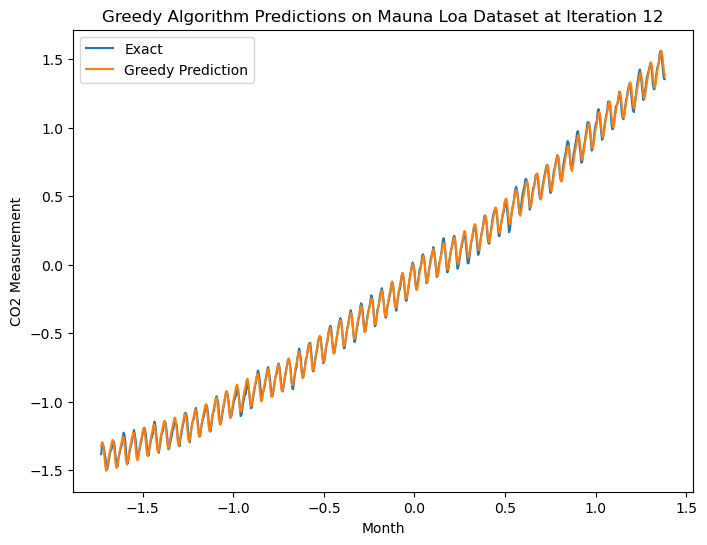

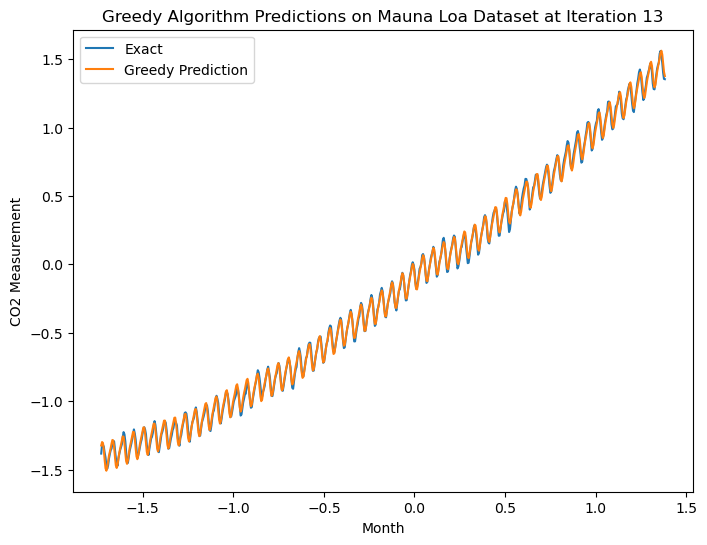

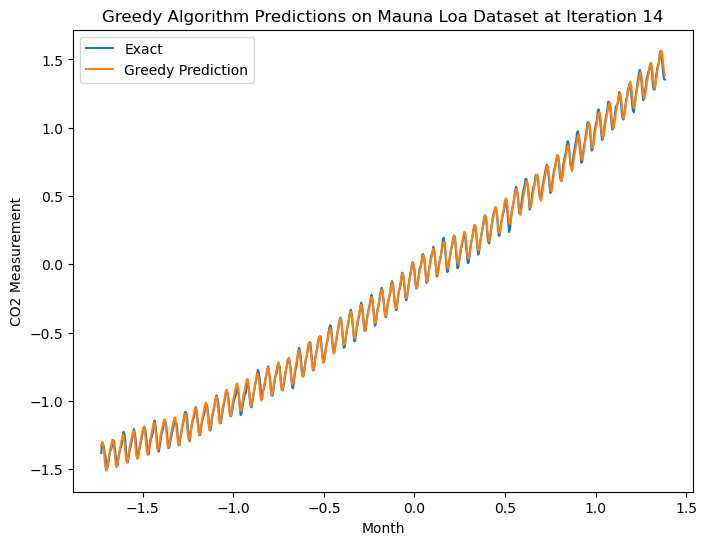

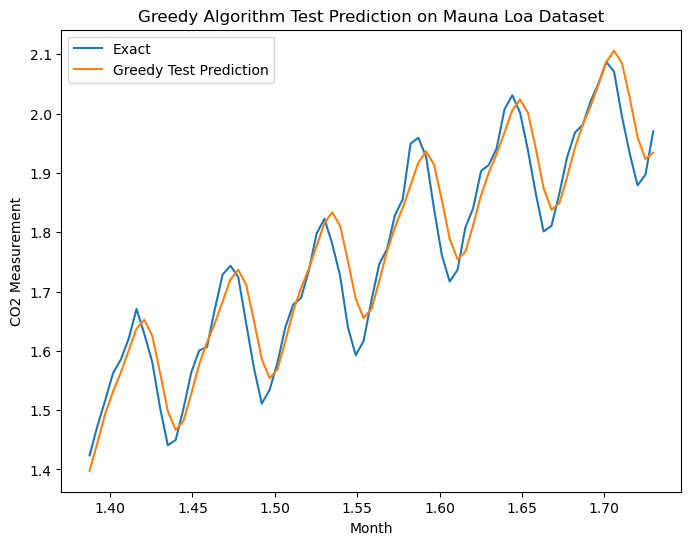

In [37]:
def poly_fnc(order):
    p = lambda x: x**order
    return p

def sine_fnc(w):
    # Multiplying the sine term by pi to get the oscillatory behaviour from the frequency w, otherwise oscillations are too small
    s = lambda x: np.sin(w*np.pi*x)
    return s

def cos_fnc(w):
    # Multiplying the cosine term by pi to get the oscillatory behaviour from the frequency w, otherwise oscillations are too small
    c = lambda x: np.cos(w*np.pi*x)
    return c

def create_basis_dict():
    '''Create dictionary for basis functions to iterate on'''
    # Mauna loa dataset looks like a combination of polynomial, sine and cosine functions when plotting the original data
    D = []
    deg = 3 # As you increase the polynomial max degree, the test rmse error increases, so changed from deg = 7 to deg = 3
    # Generate 200 basis functions: use sine and cosine functions with different frequencies, as well as polynomials up to degree 6
    N = (200-deg+1)//2
    for order in range(deg+1):
        D.append(poly_fnc(order))
    for w in range(1,N):
        D.append(sine_fnc(w))
        D.append(cos_fnc(w))
    
    return D

def ortho_match_pursuit(x_train, x_test, y_train, y_test, D):
    '''Use algorithm to determine which basis functions minimize the loss, then use those basis functions and weights from algo as our final sparse model to predict on'''
    k = 0 # iteration number
    N = x_train.shape[0]
    r = y_train # r0 residual initialization
    I_selected = []
    I_candidates = np.arange(0,len(D))
    mdl = np.inf

    # MDL metric will decrease as model complexity (k) grows, and then increase as overfitting starts to occur: stop before this increase begins
    while I_candidates.shape[0] > 0:
        k += 1
        J_phi = []
        for i in I_candidates:
            # Create J_phi matrix
            basis = D[i](x_train)
            phi_i = np.array(basis)
            J_phi += [np.square(np.matmul(phi_i.T, r))/(np.matmul(phi_i.T, phi_i))]
        # Pick a new basis function from the dictionary
        i_k = np.argmax(J_phi)
        I_selected += [I_candidates[i_k]] # Adding selected basis function index to selected
        I_candidates = np.delete(I_candidates, i_k) # Remove chosen from candidates array
        # Solve linear equation for weights (use SVD since most reliable: don't know if matrix is SPD or not to use the other options)
        Phi_k = np.empty((N,k))
        for i, ind in enumerate(I_selected):
            # Generate Phi(k)
            Phi_k[:,i] = D[ind](x_train.T)
        # Compute SVD on x_train to get U, V^T, and singular matrix
        U,S,V = svd(Phi_k, full_matrices=False)
        # Minimize least squares error by choosing w to be this expression, made up of the SVD components of X
        w = V.T.dot(U.T.dot(y_train)/(S.reshape(-1,1)))
        y_predict = Phi_k.dot(w)
        # Update residual and calculate MDL
        r = y_train - y_predict
        l2 = np.sqrt(np.sum(np.square(r)))
        mdl_k = (N/2)*np.log(l2) + (k/2)*np.log(N)

        # Plot how prediction improves with more basis functions
        plt.figure(figsize=(8,6))
        plt.plot(x_train,y_train,label='Exact')
        plt.plot(x_train, y_predict, label='Greedy Prediction')
        plt.legend(loc=0)
        plt.title(f'Greedy Algorithm Predictions on Mauna Loa Dataset at Iteration {k}')
        plt.xlabel('Month')
        plt.ylabel('CO2 Measurement')

        # Check for end of greedy algorithm
        if mdl_k < mdl:
            mdl = mdl_k
        elif mdl_k >= mdl:
            break

    # Predict on the test set using the final sparse model generated by the basis functions and weights determined in the greedy algorithm
    Phi_k = np.empty((x_test.shape[0], len(I_selected)))
    for i, ind in enumerate(I_selected):
        # Generate Phi(k)
        Phi_k[:,i] = D[ind](x_test.T)
    
    y_predict = Phi_k.dot(w)
    rmse = np.sqrt(np.mean(np.square(y_predict-y_test)))
    plt.figure(figsize=(8,6))
    plt.plot(x_test,y_test,label='Exact')
    plt.plot(x_test, y_predict, label='Greedy Test Prediction')
    plt.legend(loc=0)
    plt.title(f'Greedy Algorithm Test Prediction on Mauna Loa Dataset')
    plt.xlabel('Month')
    plt.ylabel('CO2 Measurement')

    return rmse
    
def run_Q4():
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')
    # Use training and validation data to predict on test set
    x_train = np.vstack([x_valid, x_train])
    y_train = np.vstack([y_valid, y_train])
    D = create_basis_dict()
    rmse = ortho_match_pursuit(x_train, x_test, y_train, y_test, D)

    return rmse

run_Q4()